<a href="https://colab.research.google.com/github/tjturnage/radar/blob/main/MRMS_HailRotTracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRMS Hailswaths and Rotation Tracks**
This is a notebook originally developed by Caleb Steele (former National Weather Service employee, but [here's his github profile](https://github.com/csteele2/Wx4Colab) that walks through obtaining and plotting MRMS hailswaths or rotation tracks and associated LSRs using pygrib, matplotlib, and contextily. <br/>
<br/>
Uses https://mrms.ncep.noaa.gov/data/2D/ for near real time, and https://mtarchive.geol.iastate.edu or [AWS](https://noaa-mrms-pds.s3.amazonaws.com/index.html) (starting 7/21/2022) for archive/past data. The ISU archive only has the 24hr files, and sometimes, the filenames follow a different pattern, so it might error out even if there is a file there (just try another source if that happens). <br/>
<br/>

*06-Apr-2023<br/>
TJ Turnage - updated to change method to install GIS libraries*<br/>
https://github.com/tjturnage




---



## **1 - Start here**
This first cell will take a while to run.

In [ ]:
#@title
# These libraries are needed for the pygrib library in Colab.
# Note that is needed if you install pygrib using pip.
# If you use conda, the libraries will be installed automatically.
! apt-get install libeccodes-dev libproj-dev --quiet

# Install the python packages
! pip install pyproj --quiet
! pip install pygrib --quiet

In [ ]:
#@title
# Uninstall existing shapely
# We will re-install shapely in the next step by ignoring the binary
# wheels to make it compatible with other modules that depend on
# GEOS, such as Cartopy (used here).
!pip uninstall --yes shapely --quiet

This cell installs the final round of GIS libraries, which could take a while too.

In [ ]:
# To install cartopy in Colab using pip, we need to install the library
# dependencies first.
!apt-get install -qq libgdal-dev libgeos-dev
!pip install shapely --no-binary shapely --quiet
!pip install cartopy --quiet
!pip install contextily --quiet

## **2 - Install and import packages**
In the google colab environment, we get a mismatch of cartopy and shapely, and generally revert to an older version of cartopy that has issues with the web mercator projection (which the contextily map tiles use).

In [ ]:
import os
import pandas as pd
import pygrib
import numpy as np
import numpy.ma as ma
import os
from urllib.request import urlretrieve

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.transforms import Bbox
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline


from pyproj.crs import CRS

from datetime import datetime, timedelta

from cartopy import cartopy, crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import contextily as cx
from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings("ignore")

## **3 - Edit form options and go!**
I've wrapped all the configuration entry into a form and hid nearly all of the underlying code beneath it. For the most part, making changes and running the form is all you need, but if you like, you can "Show Code" to see what's under the hood.

Looking for grib file...
   > Downloading grib
   > Processing grib file
   > Trimming data
Making rotation track plot
   > Initializing map
   > Adding fancy map tiles
   > Contouring rotation tracks
   > Adding legend
   > Adding inset map
   > Finishing up and saving plot
   > Plot saved as MRMS_RotationTrack_6hr_2024050802_LowLevelStormRotationover6hoursendingat10:00PMEDTonMay7,2024.png


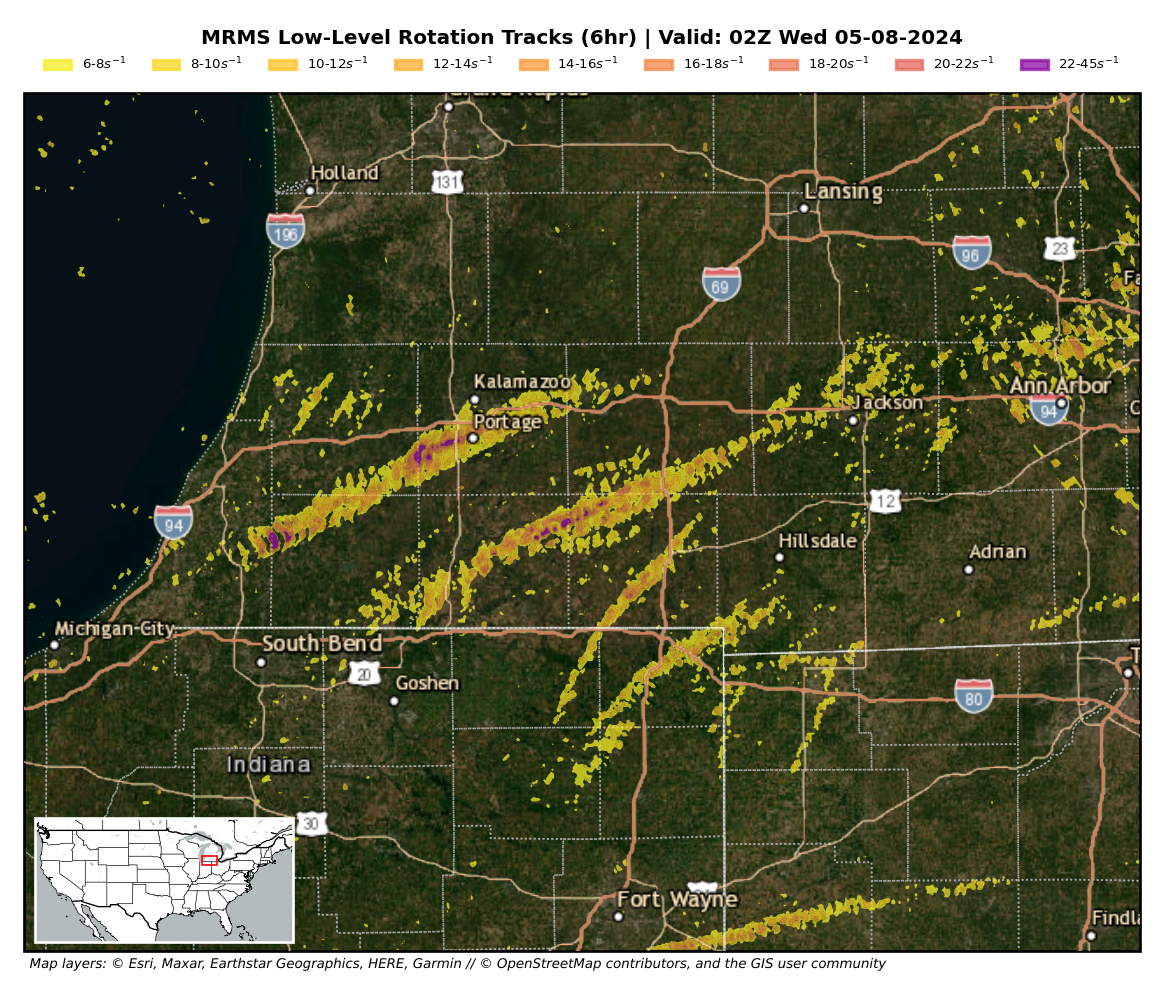

In [ ]:
# This first block of code makes a form, if the proper environment is set up.
# If you don't see a form, don't work, you can still just edit the variable sets below

#@title MRMS Hailswath/Rotation Tracks Config { display-mode: "form" }
#@markdown ### <b>Pick a Data Source </b> <br/>
#@markdown *(NCEP: Near Real-Time, AWS: Archive (since 7/21/22), ISU (fewer daily files))*
source = "AWS" #@param ["NCEP", "AWS", "ISU"]
#@markdown ### <b> Pick a Product</b>
product = "Low-level Rotation Tracks" #@param ["Hailswath", "Low-level Rotation Tracks", "Mid-level Rotation Tracks"]
#@markdown ### <b> Pick a Valid Date</b>
valid_date_input = "2024-05-08" #@param {type:"date"}
#@markdown ### <b> Pick a Valid Hour</b>
valid_hour = 2 #@param {type:"slider", min:0, max:23, step:1}
#@markdown ### <b> Pick a Valid Duration</b>
valid_duration_input = "30min" #@param ["30min", "1hr", "2hr", "4hr", "6hr", "24hr"]
#@markdown ### <b> Pick a Domain</b>
dom = "Custom" #@param ["CONUS","ECONUS","WR","ID-MT","UT","SWUS","AZ","PNW","SR","ER","CR", "co", "midwest","Custom"]
#@markdown Enter a custom name if you want (mainly used for filename)
custom_name = "Low Level Storm Rotation over 6 hours ending at 10:00 PM EDT on May 7, 2024" #@param {type:"string"}
#@markdown Enter custom lat/lon bounding box if custom was selected
custom_bottom_lat =  41.0 #@param {type:"number"}
custom_left_lon = -87.0 #@param {type:"number"}
custom_top_lat = 43.0 #@param {type:"number"}
custom_right_lon = -83.5 #@param {type:"number"}

#@markdown ### <b> Do you want LSRs?</b>
lsr_opt = False #@param {type:"boolean"}

#@markdown ### <b> Do you want CWA boundaries?</b>
cwa_opt = False #@param {type:"boolean"}

#@markdown ### <b> Do you want county boundaries?</b>
county_opt = True #@param {type:"boolean"}

if source == "ISU" and valid_duration_input != "24hr":
  print("Archive only has 24hr valid durations. Changing this for you, but next time try to be more careful!")
  valid_duration_input = "24hr"

########################################################################################################################

maplayertext1, maplayertext2 = "",""
proj = ccrs.epsg(3857)
#proj = ccrs.Mercator.GOOGLE
latloncrs = ccrs.PlateCarree()

domain_dict = {"Custom":{"west":custom_left_lon,
                        "east":custom_right_lon,
                        "north":custom_top_lat,
                        "south":custom_bottom_lat,
                        "zoom_adj": 0},

               "Utah":{"west":-117.02,
                      "east":-106.92,
                      "north":42.13,
                      "south":36.80,
                      "zoom_adj": 1},

}

west = domain_dict[dom]["west"]
south = domain_dict[dom]["south"]
east = domain_dict[dom]["east"]
north = domain_dict[dom]["north"]
map_zoom_offset = domain_dict[dom]["zoom_adj"]
########################################################################################################################

valid_duration_dict = {"30min":"30","1hr":"60","2hr":"120","4hr":"240","6hr":"360","24hr":"1440"}
valid_date = datetime.strptime(valid_date_input,'%Y-%m-%d')
valid_date += timedelta(hours = valid_hour)

if source == "ISU":
  url_base = "https://mtarchive.geol.iastate.edu/"+valid_date.strftime('%Y/%m/%d')+"/mrms/ncep/"
  if product == "Hailswath":
    dir = "MESH_Max_1440min/"
    if valid_date <= datetime(2022,6,13):
      file = "MRMS_Max_"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"
    else:
      file = "MESH_Max_"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"
  elif product == "Low-level Rotation Tracks":
    dir = "RotationTrack1440min/"
    file = "RotationTrack"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"

elif source == "NCEP":
  url_base = "https://mrms.ncep.noaa.gov/data/2D/"
  if product == "Hailswath":
    dir = "MESH_Max_"+valid_duration_dict[valid_duration_input]+"min/"
    file = "MRMS_MESH_Max_"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"
  elif product == "Low-level Rotation Tracks":
    dir = "RotationTrack"+valid_duration_dict[valid_duration_input]+"min/"
    file = "MRMS_RotationTrack"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"
  elif product == "Mid-level Rotation Tracks":
    dir = "RotationTrackML"+valid_duration_dict[valid_duration_input]+"min/"
    file = "MRMS_RotationTrackML"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"

elif source == "AWS":
  url_base = "https://noaa-mrms-pds.s3.amazonaws.com/CONUS/"
  if product == "Hailswath":
    dir = "MESH_Max_"+valid_duration_dict[valid_duration_input]+"min_00.50/"+valid_date.strftime('%Y%m%d')+"/"
    file = "MRMS_MESH_Max_"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"
  elif product == "Low-level Rotation Tracks":
    dir = "RotationTrack"+valid_duration_dict[valid_duration_input]+"min_00.50/"+valid_date.strftime('%Y%m%d')+"/"
    file = "MRMS_RotationTrack"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"
  elif product == "Mid-level Rotation Tracks":
    dir = "RotationTrackML"+valid_duration_dict[valid_duration_input]+"min_00.50/"+valid_date.strftime('%Y%m%d')+"/"
    file = "MRMS_RotationTrackML"+valid_duration_dict[valid_duration_input]+"min_00.50_"+valid_date.strftime('%Y%m%d-%H0000')+".grib2"

url = url_base+dir+file+".gz"

########################################################################################################################

print('Looking for grib file...')
if os.path.exists(file):
  print("   > Grib already exists")
else:
  try:
    print("   > Downloading grib")
    urlretrieve(url, file+".gz")
    command = f'gunzip {file}.gz'
    os.system(command)
  except:
    print("     >> Unable to get file")
print('   > Processing grib file')
grbs = pygrib.open(file)
mrms = grbs.message(1).values
mrms[mrms < 0.] = np.nan
lats, lons = grbs.message(1).latlons()
anal_time = grbs.message(1).analDate
vtime = grbs.message(1).validDate
grbs.close()

print('   > Trimming data')
west_mask = np.where(lons < (west+360.), np.nan, mrms)
east_mask = np.where(lons > (east+360.), np.nan, west_mask)
south_mask = np.where(lats < south, np.nan, east_mask)
mrms_masked = np.where(lats > north, np.nan, south_mask)

nans = np.isnan(mrms_masked)
nancols = np.all(nans, axis=0)
nanrows = np.all(nans, axis=1)
firstcol = nancols.argmin()
firstrow = nanrows.argmin()
lastcol = len(nancols) - nancols[::-1].argmin()
lastrow = len(nanrows) - nanrows[::-1].argmin()
mrms_crop = mrms[firstrow:lastrow,firstcol:lastcol]
lons_crop = lons[firstrow:lastrow,firstcol:lastcol]
lats_crop = lats[firstrow:lastrow,firstcol:lastcol]

########################################################################################################################

###### FUNCTION TO USE FONT AS GLYPH MARKERS IN SCATTERPLOT ############################################################
font_exists = os.path.exists("Font_Awesome_6_Free-Solid-900.otf")
if font_exists:
  pass
else:
  urlretrieve("https://www.dynamicmeteorology.com/style/Font_Awesome_6_Free-Solid-900.otf", "Font_Awesome_6_Free-Solid-900.otf")
fp = FontProperties(fname=r"Font_Awesome_6_Free-Solid-900.otf")

def get_marker(symbol):
    v, codes = TextToPath().get_text_path(fp, symbol)
    v = np.array(v)
    mean = np.mean([np.max(v,axis=0), np.min(v, axis=0)], axis=0)
    return Path(v-mean, codes, closed=False)


###### TIMESTRING FUNCTION #############################################################################################

def timestring(modeltime):
    #curtime_str = '%02.0f' % curtime
    #modeldt = datetime.strptime(modeltime,'%Y-%m-%d %H:%M:%S')
    #outtime = '%sZ F%s' % (wrfdt.strftime('%a %m-%d-%y %H%M'),curtime_str)
    outtime = '%s' % (modeltime.strftime('%HZ %a %m-%d-%Y'))
    return outtime

##### BLANK MAP FUNCTION ###############################################################################################
'''
Here is where you set up the domain.
Want to add another? Just copy the last (elif) one and change the bounds (try to keep it square)
Note the attributes are turned OFF on the cx.add_basemap layers IF you have mixed and matched provider sources. \
This is because each attribution goes on top of the other, and thus are manually added so they remain legible.
'''

def blankmap():
    global maplayertext1, maplayertext2, ax
    print('   > Initializing map')
    plt.figure(figsize=(6,5),frameon=True)
    F = plt.gcf()  # Gets the current figure

    ax = plt.axes(projection=proj)

    zoom = (cx.tile._calculate_zoom(west,
                                    south,
                                    east,
                                    north) - map_zoom_offset)

    ax.set_extent([west,
                  east,
                  south,
                  north], crs=latloncrs)

    ax.set_facecolor('black') #Darken the map background a bit
    print('   > Adding fancy map tiles')
    #ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#FAFAF8', zorder=-2)
    #cx.add_basemap(ax, source="https://services.arcgisonline.com/arcgis/rest/services/Elevation/World_Hillshade/MapServer/tile/{z}/{y}/{x}",
    #                attribution=False, crs=CRS.from_epsg(3857), zorder=-1)
    cx.add_basemap(ax, source="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
                    attribution=False, alpha=0.7, zorder=-1)
    maplayertext1 = "© Esri, Maxar, Earthstar Geographics, HERE, Garmin" #for MapTiler Hillshade
    #ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over the ocean
    #ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
    cx.add_basemap(ax, source="https://services.arcgisonline.com/arcgis/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}",
                    attribution=False, zoom=zoom, zorder=25)
    cx.add_basemap(ax, source='https://services.arcgisonline.com/arcgis/rest/services/Reference/World_Transportation/MapServer/tile/{z}/{y}/{x}',
                   zoom=zoom, zorder=24)
    maplayertext2 = "© OpenStreetMap contributors, and the GIS user community"

    if cwa_opt:
      try:
        if os.path.exists("shp/w_22mr22.shp"):
          pass
        else:
          cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
          cmd_mkshp = 'mkdir shp'
          os.system(cmd_mkshp)
          urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
          cmd_uz = 'unzip shp/nws_cwa_outlines.zip -d shp'
          os.system(cmd_uz)
        cwa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='darkgrey', facecolor='none', linewidth=1.0, linestyle='solid')
        ax.add_feature(cwa_feature)
      except:
        print("Aw shucks, no CWA boundaries for you. Sorry bout that.")

    if county_opt:
      try:
        if os.path.exists("shp/c_22mr22.shp"):
          pass
        else:

          county_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_19se23.zip"
          try:
            cmd_mkshp = 'mkdir shp'
            os.system(cmd_mkshp)
          except:
            pass
          urlretrieve(county_url, "shp/nws_county_outlines.zip")
          cmd_uz2 = 'unzip shp/nws_county_outlines.zip -d shp'
          os.system(cmd_uz2)
        county_feature = ShapelyFeature(Reader("shp/c_19se23.shp").geometries(),ccrs.PlateCarree(), edgecolor='darkgrey', facecolor='none', linewidth=0.5, linestyle=':')
        ax.add_feature(county_feature)
      except:
        print("Aw shucks, no county boundaries for you. Sorry bout that.")


###### FINAL DATA+LEGEND MAPPING ########################################################################################

def drawmap(DATA,TITLESTRING,PROD,UNITS,LEVS):
    F = plt.gcf()  # Gets the current figure
    ax = plt.gca()  # Gets the current axes

    if maplayertext1 != "":
      plt.text(0.005, -0.02, 'Map layers: %s // %s' % (maplayertext1,maplayertext2), transform = ax.transAxes,
               horizontalalignment='left',fontsize=4,color='k',style='italic',
               path_effects=[PathEffects.withStroke(linewidth=1.4,foreground='w')], zorder=99)

    # Let's put together a legend instead of an ugly colorbar
    print('   > Adding legend')
    proxy = [mpatches.Patch(color = pc.get_facecolor()[0]) for pc in DATA.collections]
    LLABS = []
    for i in range(0, len(LEVS)-1):
      label = str(LEVS[i])+"-"+str(LEVS[i+1])+UNITS
      LLABS.append(label)

    #proxy = proxy[::-1]
    #LLABS = LLABS[::-1]

    l = ax.legend(handles=proxy, labels=LLABS, fontsize=4,fancybox=False,
                  title=TITLESTRING, bbox_to_anchor =(0.5, 1.01), ncol=9, loc=8,
                  frameon=False)
    l.set_zorder(100)
    plt.setp(l.get_title(), multialignment='center', fontsize=6, weight='bold')

     # Now let's add an "inset" map (only outside the current map)
    print('   > Adding inset map')

    a = ax.get_position()
    inset_rect_ax = [0.01, 0.01]
    mytrans = ax.transAxes + ax.figure.transFigure.inverted()
    infig_position = mytrans.transform(inset_rect_ax)
    #print(f'a.height = {a.height} / a.width={a.width}')
    axins = F.add_axes([infig_position[0], infig_position[1], (a.height/4.), (a.height/4.)],
                       anchor='SE',projection=ccrs.PlateCarree())
    axins.set_aspect('1')
    axins.set_extent([-125.650, -66.008, 23.077, 51.924], crs=latloncrs)
    axins.add_feature(cfeature.NaturalEarthFeature(
                      'cultural', 'admin_1_states_provinces_lines', '50m',
                       edgecolor='black', facecolor='none', linewidth=0.2), zorder=0)
    axins.add_feature(cfeature.COASTLINE, linewidth=0.2,zorder=2)
    axins.add_feature(cfeature.BORDERS, linewidth=0.4, zorder=2)
    axins.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over the ocean
    axins.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
    domain_outline = mpatches.Rectangle((west, south), (east - west), (north-south),
                                       fill=False,
                                       color='red',
                                       linewidth=0.5,
                                       zorder=2)
    axins.add_patch(domain_outline)
    for spine in axins.spines.values():
        spine.set_edgecolor('white')

    print('   > Finishing up and saving plot')

    if custom_name:
      custom_name_sanitized = custom_name.replace(" ","")
      file_id = 'MRMS_%s_%s_%s_%s' % (PROD,valid_duration_input, valid_date.strftime('%Y%m%d%H'), custom_name_sanitized)
    else:
      file_id = 'MRMS_%s_%s_%s_%s' % (PROD,valid_duration_input, valid_date.strftime('%Y%m%d%H'), dom)
    filename = '%s.png' % (file_id)
    plt.savefig(filename,bbox_inches='tight', facecolor="#FFFFFF") # Saves the figure with small margins
    print(f'   > Plot saved as {filename}')

    plt.show()


####### SPECIFIC VARIABLE PLOTTING ###########################

def plot_mrms_mesh():
  print("Making hail swath plot...")
  blankmap()
  print('   > Contouring hail swaths')

  hailswath_inches = np.multiply(mrms_crop, 0.0393701)

  hail_levs = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0]
  hail_colmap = "plasma_r"
  hail_cols = ["#3780B9", "#6EC5A4", "#C0E69F", "#FBFEB9",
               "#FED681", "#F78A4E", "#D7404E", "#9A003B", "#6E0049"]
  hail_plot = plt.contourf(lons_crop, lats_crop, hailswath_inches, hail_levs,
                           colors=hail_cols,extend='neither',alpha=0.75,
                           transform=latloncrs, antialiased = True, zorder = 5,
                           transform_first=True)
  #hail_plot = plt.contourf(lons, lats, hailswath_inches, hail_levs,cmap=plt.get_cmap(hail_colmap),extend='neither',alpha=0.75, transform=latloncrs, antialiased = True, zorder = 5)

  if lsr_opt:
    #lsr_lats, lsr_lons, lsr_mag = [], [], []
    lsr_start = vtime - timedelta (minutes=int(valid_duration_dict[valid_duration_input]))
    lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
    lsr_end = vtime.strftime('%Y-%m-%dT%H:%M')
    lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
    csv_name = "lsr_"+lsr_start.replace(':','')+"_"+lsr_end.replace(':','')+".csv"

    #try:
    lsrs_exist = os.path.exists(csv_name)
    if lsrs_exist:
        print("   > LSRs file already exists")
    else:
        print("   > Grabbing LSRs")
        urlretrieve(lsr_url, csv_name)

    LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
    LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
    LSRs['LAT'] = LSRs.LAT.astype(float)
    LSRs['LON'] = LSRs.LON.astype(float)
    #LSRs[(LSRs.TYPECODE=='5')&(LSRs.MAG>=0.1)].plot.scatter(x='LON', y='LAT', c='MAG', vmin=0, vmax=1, ec='red', s=100, transform=proj)
    LSRs_hail = LSRs[(LSRs.TYPECODE == 'H') & (LSRs.MAG >= 0.75) & (LSRs.LAT < north) & (LSRs.LAT > south) & (LSRs.LON < east) & (LSRs.LON > west)]
    hail_lats= LSRs_hail['LAT'].to_numpy()
    hail_lons= LSRs_hail['LON'].to_numpy()
    icon_size = LSRs_hail['MAG'].to_numpy()
    hail_size = LSRs_hail['MAG'].to_numpy()
    print("     >> Plotting LSRs")
    #plt.scatter(hail_lons, hail_lats, marker=get_marker("\uf73b"), color='green', edgecolor='none', s=(icon_size*40),transform=latloncrs, zorder=3)
    for report in range(0, len(hail_size)):
        ax.text(hail_lons[report], hail_lats[report],hail_size[report],fontsize=4,color='k',
                path_effects=[PathEffects.withStroke(linewidth=1.0,foreground='w')],transform=latloncrs,
                zorder=(25+hail_size[report]), ha='center', va='center')

  legend_title = f'MRMS Max Estimated Hail Size - {valid_duration_input} Swath | Valid: {timestring(vtime)}'
  units = '\"'
  prod = "Hailswath"

  drawmap(hail_plot, legend_title, prod, units, hail_levs)


def plot_mrms_rotationtrack():
  print("Making rotation track plot")
  blankmap()
  print('   > Contouring rotation tracks')

  #rot_levs = [4, 5, 6, 8, 10, 12, 14, 16, 18, 45]
  rot_levs = [6, 8, 10, 12, 14, 16, 18, 20, 22, 45]
  rot_colmap = plt.get_cmap('plasma_r')

  rt_plot = plt.contourf(lons_crop, lats_crop, mrms_crop, rot_levs, cmap=rot_colmap,extend='neither',
                         alpha=0.75, transform=latloncrs, antialiased = True, zorder = 5,
                         transform_first=True)


  if lsr_opt:
    #lsr_lats, lsr_lons, lsr_mag = [], [], []
    lsr_start = vtime - timedelta (minutes=int(valid_duration_dict[valid_duration_input]))
    lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
    lsr_end = vtime.strftime('%Y-%m-%dT%H:%M')
    lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
    csv_name = "lsr_"+lsr_start.replace(':','')+"_"+lsr_end.replace(':','')+".csv"

    #try:
    lsrs_exist = os.path.exists(csv_name)
    if lsrs_exist:
        print("   > LSRs file already exists")
    else:
        print("   > Grabbing LSRs")
        urlretrieve(lsr_url, csv_name)

    LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
    LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
    LSRs['LAT'] = LSRs.LAT.astype(float)
    LSRs['LON'] = LSRs.LON.astype(float)
    LSRs_tor = LSRs[(LSRs.TYPECODE == 'T')]
    tor_lats= LSRs_tor['LAT'].to_numpy()
    tor_lons= LSRs_tor['LON'].to_numpy()
    print("     >> Plotting LSRs")
    plt.scatter(tor_lons, tor_lats, marker=get_marker("\uf76f"), color="tab:red", edgecolor='none', s=55,transform=latloncrs, zorder=10)

  if product == "Low-level Rotation Tracks":
    legend_title = f'MRMS Low-Level Rotation Tracks ({valid_duration_input}) | Valid: {timestring(vtime)}'
    prod = "RotationTrack"
  elif product == "Mid-level Rotation Tracks":
    legend_title = f'MRMS Mid-Level Rotation Tracks ({valid_duration_input}) | Valid: {timestring(vtime)}'
    prod = "MLRotationTrack"
  units = r'$s^{-1}$'

  drawmap(rt_plot, legend_title, prod, units, rot_levs)

########################################################################################################################

matplotlib.rcParams['figure.dpi'] = 240

if product == "Hailswath":
  plot_mrms_mesh()
elif product == "Low-level Rotation Tracks":
  plot_mrms_rotationtrack()
elif product == "Mid-level Rotation Tracks":
  plot_mrms_rotationtrack()